In [1]:
%matplotlib inline
from tqdm import tqdm
import numpy as np
import pymc3 as pm
from theano import shared
import theano.tensor as tt
import theano
from pymc3.distributions.dist_math import binomln, betaln, bound
np.set_printoptions(suppress=True)

/Users/ded/anaconda3/lib/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7201 on context None
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:86:00.0)
/Users/ded/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import re
def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')
def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

In [3]:
# Import and prepare the data
import pickle
with open('data/gch-10000-20-0.25-5.00.pkl', 'rb') as f:
  GCH, TH = pickle.load(f)
S = 20
npdata = np.array(GCH, dtype = int)
V = len(GCH)
V, type(V)

# make data
captures, freqs = np.unique(npdata[:, 2], return_counts=True)
data = np.zeros(S)
data[captures - 1] = freqs
print(V)
print(data)

1316
[913. 232.  95.  37.  18.  14.   6.   1.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.]


In [4]:
# For a given outcome in {1,S} (Frequency of capture that's not 0) 
# Mark all possible arrival and departure 
# Dims: SxSxS
def make_all_ocaz(S):
    mask = np.zeros([S,S,S]) # num_capture, arrival, departure
    for p in np.arange(S):
        for a in np.arange(S):
            for d in np.arange(S):
                if (d - a) >= p:
                    mask[p, a, d] = 1
    return mask
ocaz = make_all_ocaz(S)

In [5]:
# We want to see the survival marks to compute the total survival
# e.g, Arrive: 1, Depart: 2 => 011
# Dims: SxSxS
def make_survival(S):
    mask = np.zeros([S,S,S])  # arrival, departure, presence_sequence
    for s in np.arange(S):
        for q in np.arange(s,S):
            c1 = np.zeros(s)
            c2 = np.ones(q-s)
            c3 = np.zeros(S-q)
            mask[s,q]= np.concatenate((c1, c2, c3))
    return mask
survival = make_survival(S)

In [6]:
# For a given outcome in {1,S} (Frequency of capture that's not 0) 
# Generate the Binomial parameters n and i   choose(n, i)
# Nn is the duration from arrival to departure
# Ni is the Frequency we are intersted in
# Dim: SxSxS
def make_binmask(S):
    i = np.arange(S) + 1
    i = i[:, np.newaxis, np.newaxis] *  np.ones((S, S, S))
    n = np.broadcast_to(np.triu(np.ones([S,S]), 0).cumsum(axis =1), (S, S, S))
    return i, n
Ni, Nn = make_binmask(S)

In [7]:
def get_BetaBi(a,b, S, Ni, Nn):
    # The beta binomial
    BBi  =  bound(binomln(Nn, Ni)
                     + betaln(Ni + a, Nn - Ni + b)
                     - betaln(a, b),
                     Ni >= 0, Ni <= Nn,
                     a > 0, b > 0)
    # The above is the computation of the log, so we take the exponent
    return tt.exp(BBi)

In [8]:
def get_BetaB0(a, b, S):
    # The beta binomial for 0 captures
    Nn = tt.triu(tt.ones([S,S]), 0).cumsum(axis =1).eval()
    #B0 = tt.gammaln(n + b) - tt.gammaln(n + a + b) + tt.gammaln(a + b) - tt.gammaln(b)
    B0 = bound(binomln(Nn, 0)
                     + betaln(a, Nn + b)
                     - betaln(a, b),
                     a > 0, b > 0)
    return tt.exp(B0)

In [80]:
def logp_capture(arrival_probs, departure_probs, a, b, U, V, ocaz, survival_mask, Ni, Nn, S):
    def ll_capture_f(ni):
        
        # Likelihood of observing Li captures
        
        # compute the survival
        survival_prob = tt.pow(1 - departure_probs, survival_mask)
        survival_prob = tt.prod(survival_prob, axis=2)
        # compute the arrival and departure
        LAD      = arrival_probs[:, np.newaxis] * survival_prob * departure_probs    # SxS
        # keep only true possibilites
        True_LAD = LAD * ocaz # SxSxS
        
        # sum along the freqencies of catpures
        BetaBi  = get_BetaBi(a, b, S, Ni, Nn)
        Li      = tt.batched_tensordot(True_LAD, BetaBi, axes = 2) # S
        
        # Likelihood of No-Capture L0
        
        LADT0    = LAD * ocaz[0] # this is reuse
        BetaB0   = get_BetaB0(a, b, S)
        L0       = tt.sum(LADT0 * BetaB0)
        
        #print(L0.eval())
        
        # Multinomial
        obj1 = tt.gammaln(V + U + 1) - tt.gammaln(U + 1) - tt.sum(tt.gammaln(ni+1))
        obj2 = tt.sum(tt.mul(ni, tt.log(Li)))
        obj3 = U * tt.log(L0)
        
        objective = obj1 + obj2 + obj3 
        
        #print(objective.eval())
        return objective
    
    return ll_capture_f

In [77]:
#print(start['arrival'], start['departure'], start['alpha'], start['beta'], start['Unseen']
logp_capture(start['arrival'], np.concatenate((start['departure'], np.array([1.])),  axis=0), 
             start['alpha'], start['beta'], 8684, V,
             ocaz, survival, Ni, Nn, S)(data).eval()
logp_capture(np.concatenate(([.4], np.ones(S-1) * (1-.4)/(S-1)), axis=0), 
             np.concatenate((np.ones(S-1) * .2, [1.]), axis=0), .25, 5., 8684, V, 
             ocaz, survival, Ni, Nn, S)(data).eval()

-691.9899602960921
-27.216073938284808


array(-27.21607394)

In [78]:
print(start['arrival'])
print(start['departure']) 
print(start['alpha'], start['beta'], start['Unseen'])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.4 0.4 0.4 0.4 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.4 0.4 0.4
 0.4]
0.1 10.0 20000.0


In [81]:
# custom log-liklihood
# model
with pm.Model() as model:
    # parameters
    U = pm.Uniform('Unseen', lower=0, upper=20000)
    a = pm.Uniform('alpha', .1, .5)
    b = pm.Uniform('beta', 1., 10.)
    
    phi = tt.zeros(S)
    phi_v    = pm.Uniform('departure', 0.1, .3, shape=S-1)
    phi = tt.set_subtensor(phi[S-1], 1.)
    phi = tt.set_subtensor(phi[:S-1],phi_v)
    
    arr    = pm.Dirichlet('arrival', a=np.array([1./S]*S), shape=S)
    #U_print = tt.printing.Print('Unseen')(U)
    #a_print = tt.printing.Print('alpha')(a)
    #b_print = tt.printing.Print('beta')(b)
    # Model Log-likelihood
    ob = pm.DensityDist('x', logp_capture(arr, phi, a, b, U, V, ocaz, survival, Ni, Nn, S), observed=data)

In [57]:
with model:
    start = pm.find_MAP()

logp = -22.362, ||grad|| = 4.4384: 100%|██████████| 18/18 [00:00<00:00, 212.35it/s]  


In [58]:
start

{'Unseen_interval__': array(405.85618959),
 'alpha_interval__': array(-898.13439986),
 'beta_interval__': array(32.6743512),
 'departure_interval__': array([ 251.83369778,  335.92183032,  297.40045156,  169.24186075,
         -21.9054935 , -219.96089535, -379.87273893, -486.66583465,
        -544.6917201 , -562.47793409, -544.00423599, -486.23686226,
        -381.99865218, -228.35597385,  -40.01255071,  141.73812571,
         266.36478813,  309.08730493,  237.04744207]),
 'arrival_stickbreaking__': array([ -146.59538912,   -62.14177245,   174.00609204,   222.42891512,
          381.05002666,   549.57664341,   716.49707049,   863.4963885 ,
          963.96163074,   982.60275359,   878.15684487,   612.6734895 ,
          172.38541851,  -395.9614222 ,  -943.96478752, -1250.96109973,
        -1226.34979356, -1049.85890616,  -662.50282862]),
 'Unseen': array(20000.),
 'alpha': array(0.1),
 'beta': array(10.),
 'departure': array([0.4, 0.4, 0.4, 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0

In [84]:
with model:
  posterior = pm.sample(5000, chains = 4, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [arrival, departure, beta, alpha, Unseen]
100%|██████████| 5500/5500 [18:00<00:00,  5.09it/s]
There were 2814 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5494 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8245 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11248 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


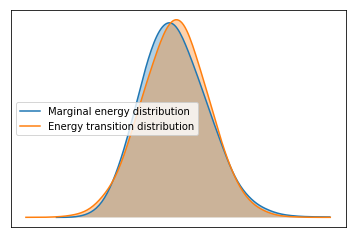

In [85]:
pm.energyplot(posterior);

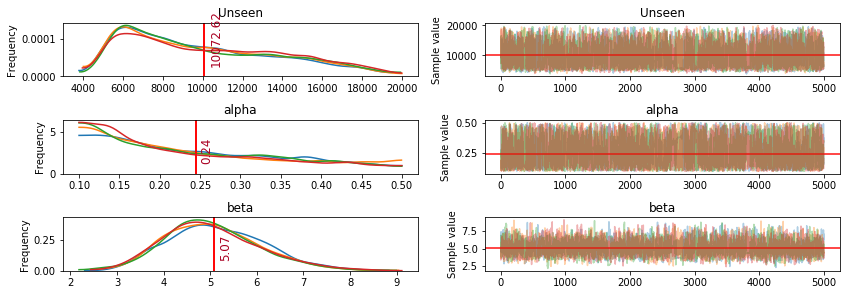

In [86]:
plot_traces(posterior[:], varnames=['Unseen', 'alpha', 'beta']);

In [87]:
pm.summary(posterior).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Unseen,10072.62,3838.22,80.84,4658.16,17403.18,3089.89,1.0
alpha,0.24,0.11,0.00,0.10,0.46,2647.02,1.0
beta,5.07,1.02,0.02,3.21,7.16,2623.13,1.0
departure__0,0.20,0.06,0.00,0.11,0.30,6835.85,1.0
departure__1,0.20,0.06,0.00,0.10,0.29,5788.68,1.0
departure__2,0.20,0.06,0.00,0.10,0.29,6048.28,1.0
departure__3,0.20,0.06,0.00,0.11,0.30,5357.49,1.0
departure__4,0.20,0.06,0.00,0.10,0.29,5658.14,1.0
departure__5,0.20,0.06,0.00,0.10,0.29,6816.57,1.0
departure__6,0.20,0.06,0.00,0.10,0.29,4082.71,1.0


In [88]:
print("Total Workers", V + posterior['Unseen'].mean())

Total Workers 11388.620379892849


In [38]:
start['departure']

array([0.99960055, 0.98480729, 0.39762874, 0.10428072, 0.1001419 ,
       0.10003229, 0.10002592, 0.10003497, 0.10006085, 0.10013163,
       0.1003568 , 0.10129508, 0.10736397, 0.17695931, 0.73741097,
       0.99370893, 0.99996245, 0.99999998, 1.        , 1.        ])

In [45]:
np.arange(10)[:10 - 1]

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [73]:
np.concatenate((start['departure'], np.array([1.])),  axis=0)

array([0.4, 0.4, 0.4, 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0.4, 0.4, 0.4, 0.4, 1. ])